# (06) Sim -- kNN analysis

**Motivation**: Can I generate few frames per seed, and loop over many seeds? Yes! <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from figures.fighelper import *
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _do_pca(a):
    a = flatten_arr(a, ndim_end=0, ndim_start=1)
    u, s, v = sp_lin.svd(a, full_matrices=False, compute_uv=True)
    s *= 100 / s.sum()
    titles = [f"{e:0.1f} %" for e in s]
    pcs = v.reshape(-1, of.dim, of.dim, 2)
    return s, pcs, titles


def _plot_singular_values(s, thres=90):
    fig, axes = create_figure(2, 1, (13, 7), sharex='all')
    axes[0].plot(s, marker='.')
    axes[1].plot(np.cumsum(s), lw=3, marker=None)

    idx = np.where(np.cumsum(s) > thres)[0][0]
    axes[1].axvline(
        idx, color='g', ls=':', lw=1.5,
        label=f'{idx} dimensions',
    )
    axes[1].axhline(
        thres, color='magenta', ls=':', lw=1.5,
        label=f'{thres}% of variance',
    )
    axes[1].legend()

    axes[1].axhline(0, color='k', ls='--', lw=1.2)
    axes[1].axhline(100, color='k', ls='--', lw=1.2)
    axes[1].set_ylim((-3, 103))
    add_grid(axes)
    plt.show()

    
def _sizes_hist(of, obj_i: int = 0):
    fig, ax = create_figure(1, 1, (15, 5))
    size_pix = of.objects[obj_i].size * of.dim ** 2
    sns.histplot(size_pix, bins=np.linspace(0, 80, 81) - 0.5, stat='percent', ax=ax)

    for color, thres in zip(['magenta', 'k', 'r'], [2, 4, 8]):
        lbl = f'{100 * (size_pix < thres).sum() / of.n:0.1f}% smaller than {thres} pixels'
        ax.axvline(thres, color=color, ls='--', lw=1.3, label=lbl)
    ax.legend(fontsize=17)
    plt.show()

## Prepare

In [3]:
kws = dict(
    dim=19,
    fov=45.0,
    obj_r=0.2,
    obj_bound=0.97,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 5.0),
    vlim_slf=(0.01, 5.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 4

{
    'dim': 19,
    'fov': 45.0,
    'obj_r': 0.2,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 5.0),
    'vlim_slf': (0.01, 5.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

## Category = ```Fixate```, n_obj = 1

In [4]:
%%time

of = OpticFlow(
    category='fixate',
    n=int(1e6),
    n_obj=1,
    **kws,
).compute_coords()
_ = of.compute_flow()
accept = of.filter(min_obj_size)
of.gamma = None

s, pcs, titles = _do_pca(of.alpha_dot[accept])

CPU times: user 28min 35s, sys: 7min 9s, total: 35min 44s
Wall time: 21min 43s


In [5]:
accept.sum()

826821

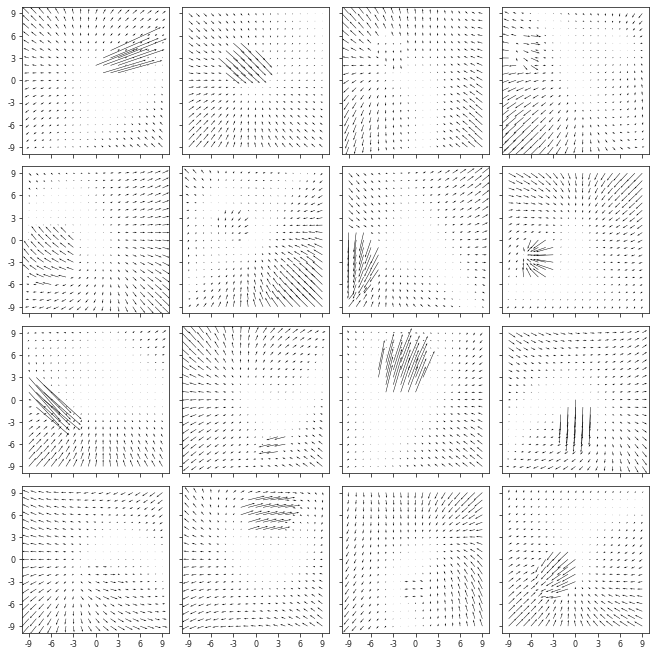

In [6]:
_ = show_opticflow(of.alpha_dot[accept], tick_spacing=3)

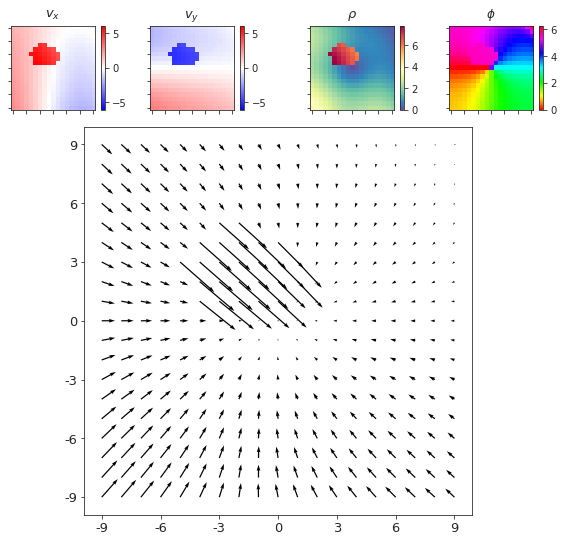

In [7]:
_ = show_opticflow_full(of.alpha_dot[accept][1], tick_spacing=3)

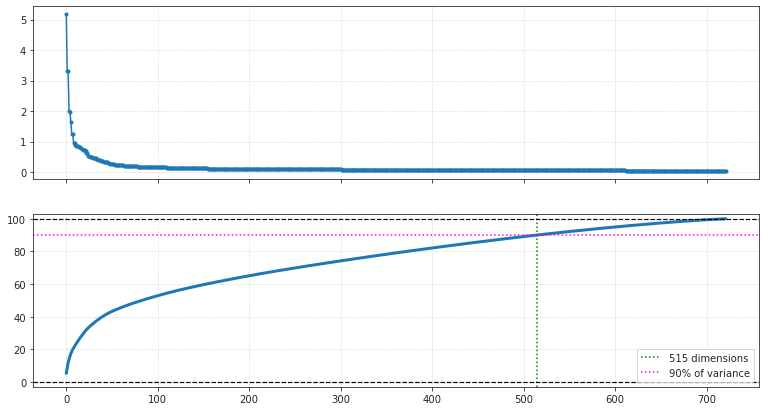

In [8]:
_plot_singular_values(s)

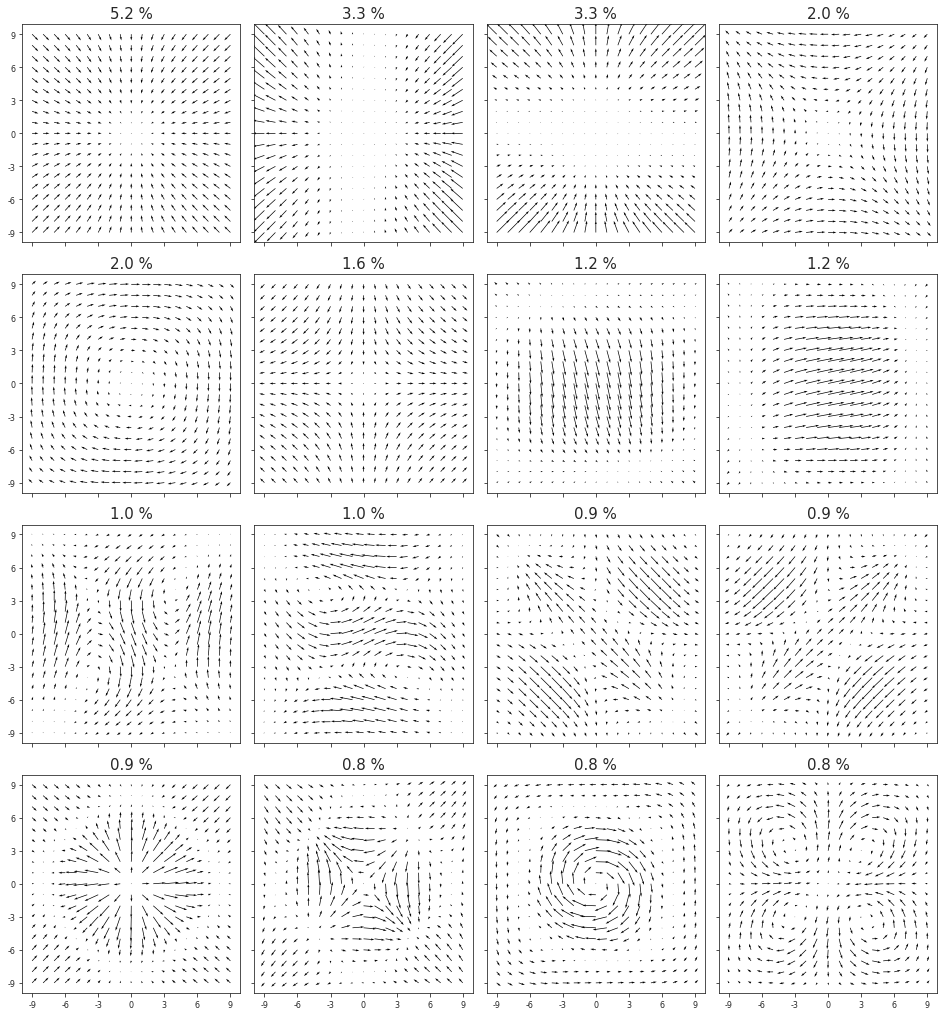

In [9]:
show_opticflow(pcs, num=4, titles=titles, scale=None, figsize=(13, 14), tick_spacing=3);

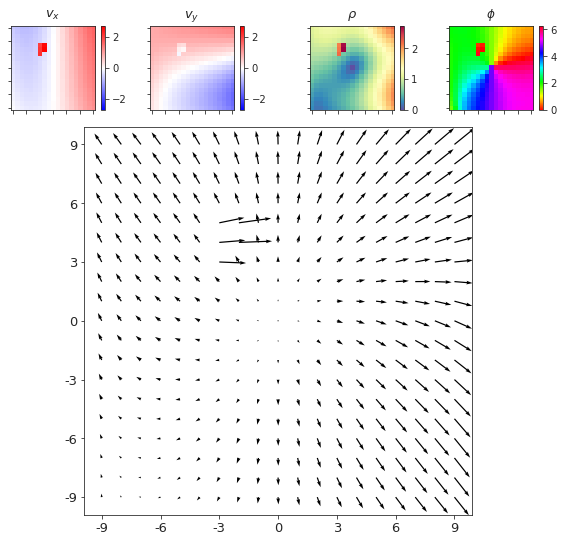

In [10]:
size_pix = of.objects[0].size * of.dim ** 2
i = np.argmin(size_pix[accept])
_ = show_opticflow_full(of.alpha_dot[accept][i])

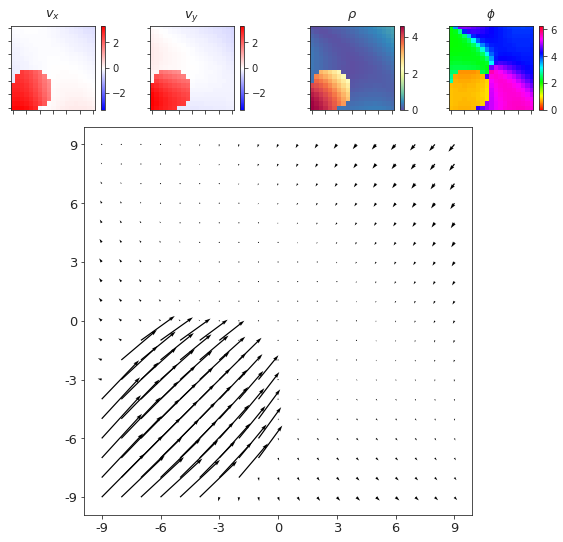

In [11]:
i = np.argmax(size_pix[accept])
_ = show_opticflow_full(of.alpha_dot[accept][i])

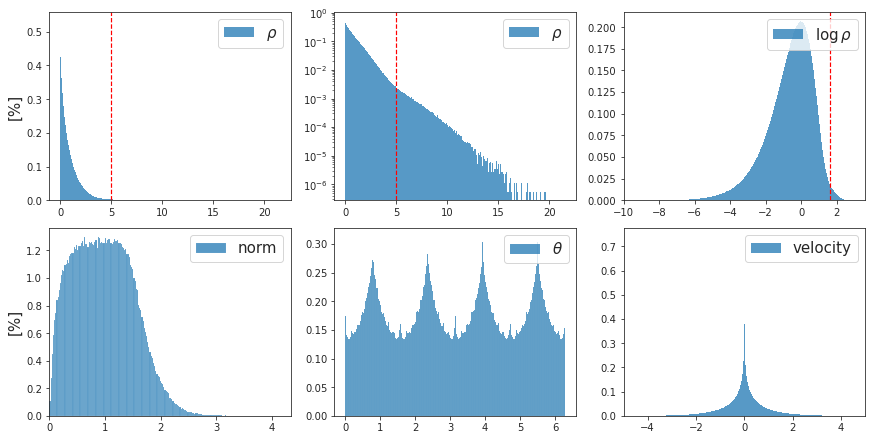

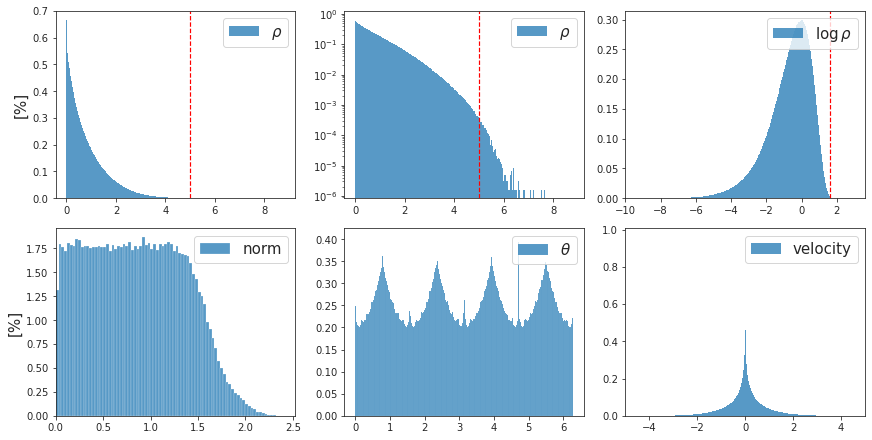

CPU times: user 14min 53s, sys: 4min 2s, total: 18min 55s
Wall time: 18min 57s


In [12]:
%%time

_ = plot_opticflow_hist(of.alpha_dot[accept][:500000])
_ = plot_opticflow_hist(of.alpha_dot[~accept])

In [13]:
q = [0.5, 0.95, 0.97, 0.99]
print(f"q = {q}\nquantiles (accept): {np.quantile(np.abs(of.alpha_dot[accept]).ravel(), q)}")

q = [0.5, 0.95, 0.97, 0.99]
quantiles (accept): [0.36739769 2.11319878 2.50637989 3.61046025]

In [14]:
q = [0.5, 0.95, 0.97, 0.99]
print(f"q = {q}\nquantiles (~accept): {np.quantile(np.abs(of.alpha_dot[~accept]).ravel(), q)}")

q = [0.5, 0.95, 0.97, 0.99]
quantiles (~accept): [0.3419571  1.82264825 2.09590173 2.59318471]

## Other hists

In [15]:
accept = of.filter(2)
accept.sum()

925874

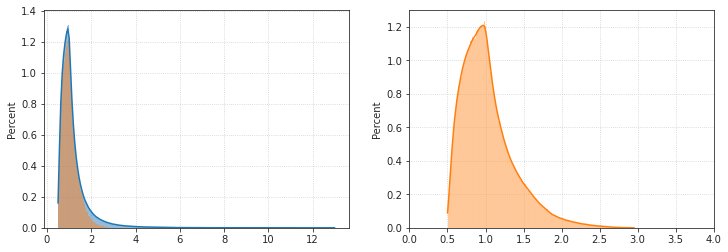

In [16]:
fig, axes = create_figure(1, 2, (12, 4))
sns.histplot(of.objects[0].r[:, 0], stat='percent', kde=True, ax=axes[0])
sns.histplot(of.objects[0].r[:, 0][accept], alpha=0.5,
             stat='percent', color='C1', ax=axes[0])
sns.histplot(of.objects[0].r[:, 0][accept], kde=True,
             stat='percent', color='C1', ax=axes[1])
axes[1].set_xlim((0, 4))
add_grid(axes)
plt.show()

In [17]:
accept = of.filter(4)
accept.sum()

826821

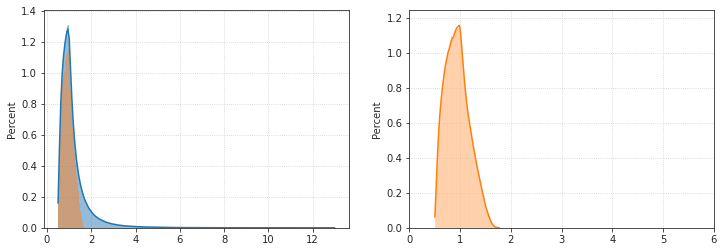

In [18]:
fig, axes = create_figure(1, 2, (12, 4))
sns.histplot(of.objects[0].r[:, 0], stat='percent', kde=True, ax=axes[0])
sns.histplot(of.objects[0].r[:, 0][accept], alpha=0.5,
             stat='percent', color='C1', ax=axes[0])
sns.histplot(of.objects[0].r[:, 0][accept], kde=True,
             stat='percent', color='C1', ax=axes[1])
axes[1].set_xlim((0, 6))
add_grid(axes)
plt.show()

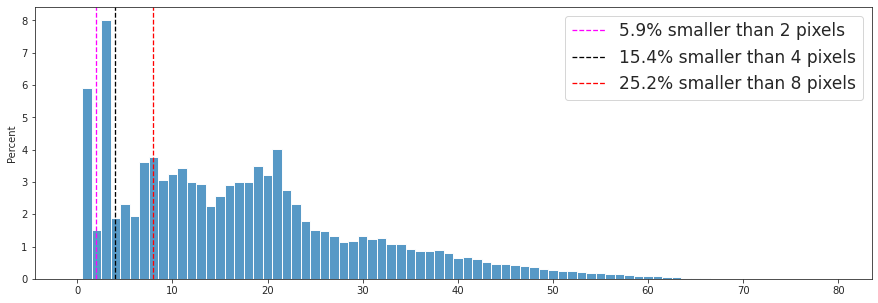

In [19]:
_sizes_hist(of)

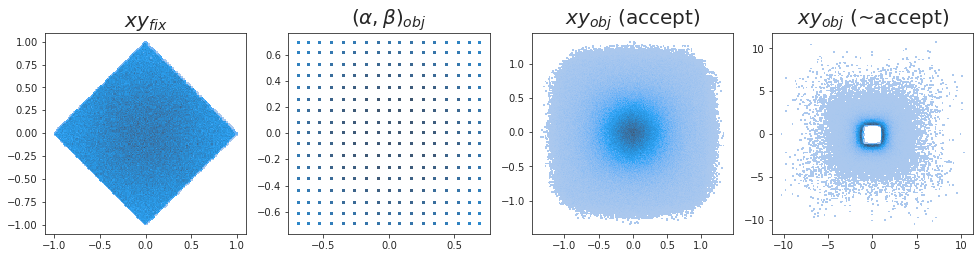

In [20]:
fig, axes = create_figure(1, 4, (13.5, 3.5), constrained_layout=True)
sns.histplot(
    x=of.fix[accept, 0],
    y=of.fix[accept, 1],
    ax=axes[0],
)
sns.histplot(
    x=of.objects[0].alpha[accept, 0],
    y=of.objects[0].alpha[accept, 1],
    ax=axes[1],
)
sns.histplot(
    x=of.objects[0].pos[accept, 0],
    y=of.objects[0].pos[accept, 1],
    ax=axes[2],
)
sns.histplot(
    x=of.objects[0].pos[~accept, 0],
    y=of.objects[0].pos[~accept, 1],
    ax=axes[3],
)

axes[0].set_title(r"$xy_{fix}$", fontsize=20)
axes[1].set_title(r"$(\alpha,\beta)_{obj}$", fontsize=20)
axes[2].set_title(r"$xy_{obj}$ (accept)", fontsize=20)
axes[3].set_title(r"$xy_{obj}$ (~accept)", fontsize=20)

ax_square(axes)
plt.show()

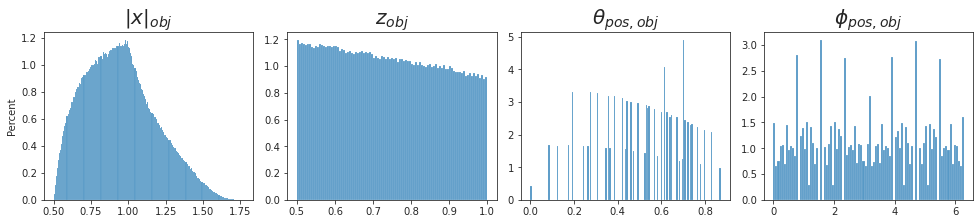

In [21]:
fig, axes = create_figure(1, 4, (13.5, 3), constrained_layout=True)
sns.histplot(of.objects[0].r[accept, 0], stat='percent', ax=axes[0])
sns.histplot(of.objects[0].pos[accept, 2], stat='percent', ax=axes[1])
sns.histplot(of.objects[0].r[accept, 1], stat='percent', ax=axes[2])
sns.histplot(of.objects[0].r[accept, 2], stat='percent', ax=axes[3])

axes[0].set_title(r"$\|x|_{obj}$", fontsize=20)
axes[1].set_title(r"$z_{obj}$", fontsize=20)
axes[2].set_title(r"$\theta_{pos, obj}$", fontsize=20)
axes[3].set_title(r"$\phi_{pos, obj}$", fontsize=20)

for ax in axes[1:].flat:
    ax.set_ylabel('')
plt.show()

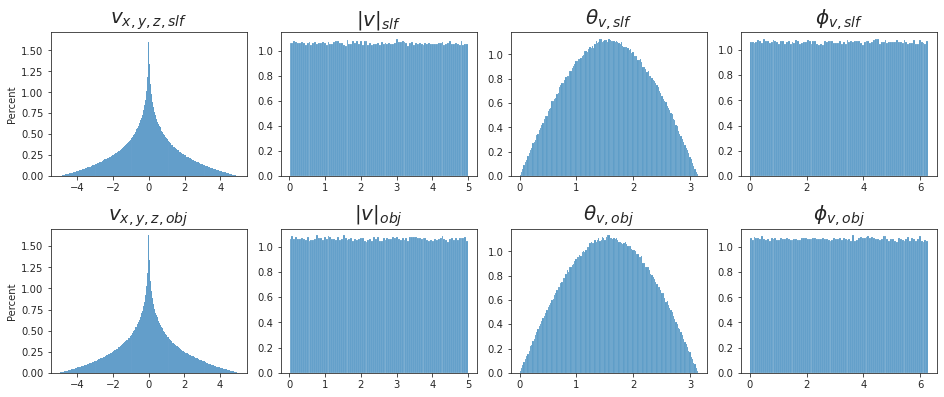

In [22]:
v_slf_polar = cart2polar(of.v_slf)
v_obj_polar = cart2polar(of.objects[0].v)

fig, axes = create_figure(2, 4, (13, 5.4), constrained_layout=True)

sns.histplot(of.v_slf[accept].ravel(), stat='percent', ax=axes[0, 0])
sns.histplot(v_slf_polar[accept, 0], stat='percent', ax=axes[0, 1])
sns.histplot(v_slf_polar[accept, 1], stat='percent', ax=axes[0, 2])
sns.histplot(v_slf_polar[accept, 2], stat='percent', ax=axes[0, 3])

sns.histplot(of.objects[0].v[accept].ravel(), stat='percent', ax=axes[1, 0])
sns.histplot(v_obj_polar[accept, 0], stat='percent', ax=axes[1, 1])
sns.histplot(v_obj_polar[accept, 1], stat='percent', ax=axes[1, 2])
sns.histplot(v_obj_polar[accept, 2], stat='percent', ax=axes[1, 3])

axes[0, 0].set_title(r"$v_{x,y,z, slf}$", fontsize=20)
axes[1, 0].set_title(r"$v_{x,y,z, obj}$", fontsize=20)
axes[0, 1].set_title(r"$|v|_{slf}$", fontsize=20)
axes[1, 1].set_title(r"$|v|_{obj}$", fontsize=20)
axes[0, 2].set_title(r"$\theta_{v, slf}$", fontsize=20)
axes[1, 2].set_title(r"$\theta_{v, obj}$", fontsize=20)
axes[0, 3].set_title(r"$\phi_{v, slf}$", fontsize=20)
axes[1, 3].set_title(r"$\phi_{v, obj}$", fontsize=20)

for ax in axes[:, 1:].flat:
    ax.set_ylabel('')
plt.show()

## Factors

In [23]:
f, g, f_aux, g_aux = of.groundtruth_factors()

### Plot correlations

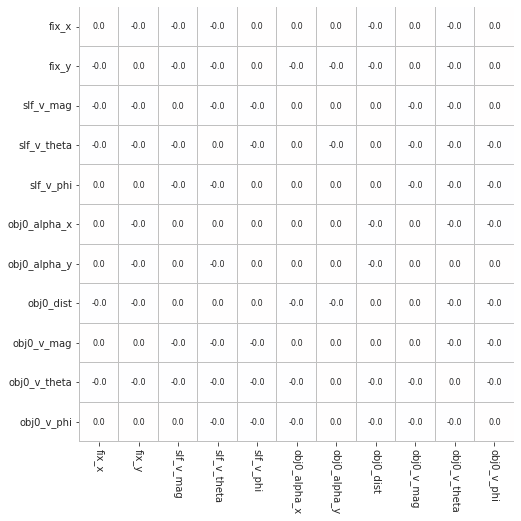

In [24]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g, metric='correlation'))
np.fill_diagonal(rho, 0)

kws_hm = dict(
    xticklabels=f,
    yticklabels=f,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(10, 8),
    cbar=False,
)
show_heatmap(rho, **kws_hm);

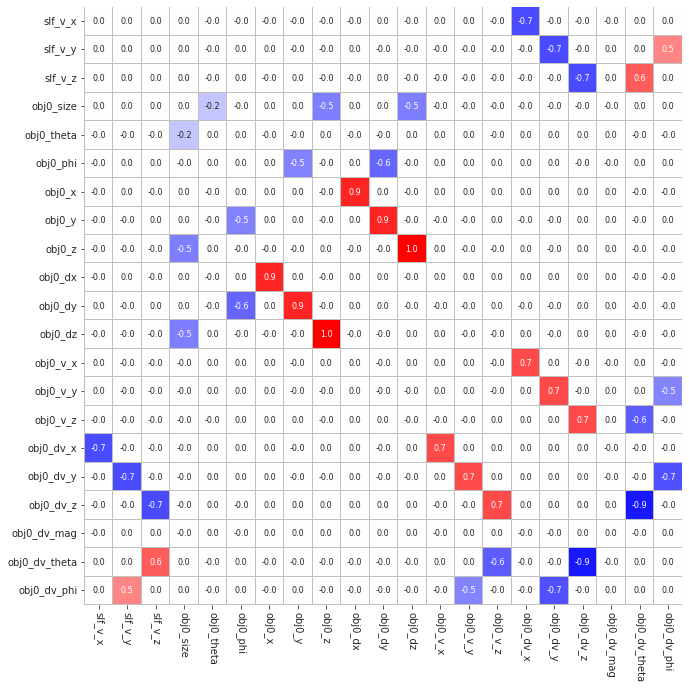

In [25]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_aux, metric='correlation'))
np.fill_diagonal(rho, 0)

kws_hm = dict(
    xticklabels=f_aux,
    yticklabels=f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(13, 11),
    cbar=False,
)
show_heatmap(rho, **kws_hm);

In [26]:
g_full = np.concatenate([g, g_aux])
g_full.shape

(32, 1000000)

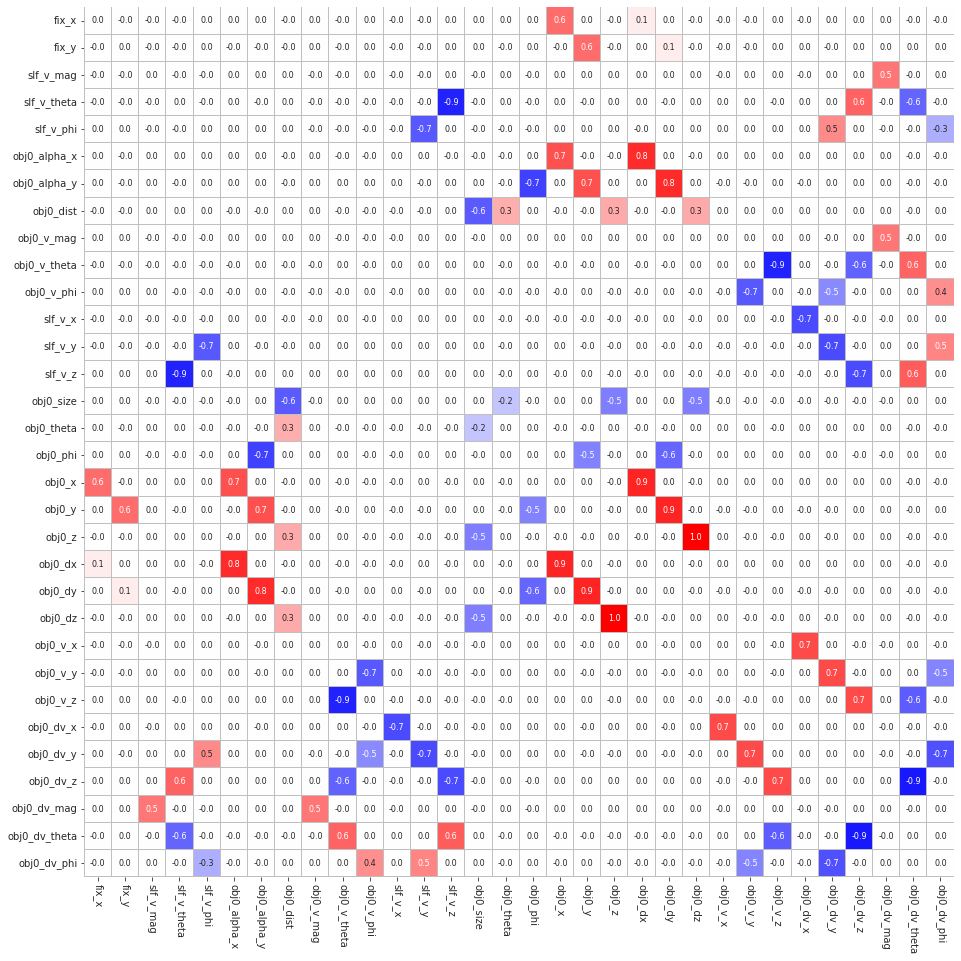

In [27]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_full, metric='correlation'))
np.fill_diagonal(rho, 0)

kws_hm = dict(
    xticklabels=f + f_aux,
    yticklabels=f + f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(17, 16),
    cbar=False,
)
show_heatmap(rho, **kws_hm);

### Correlations (accepted only)

In [28]:
accept.sum()

826821

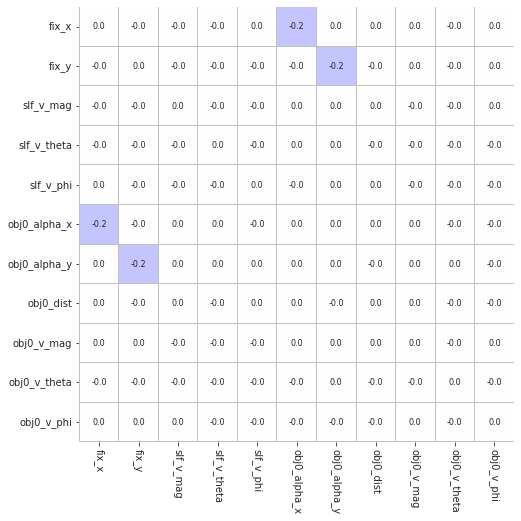

In [29]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g[:, accept], metric='correlation'))
np.fill_diagonal(rho, 0)

kws_hm = dict(
    xticklabels=f,
    yticklabels=f,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(10, 8),
    cbar=False,
)
show_heatmap(rho, **kws_hm);

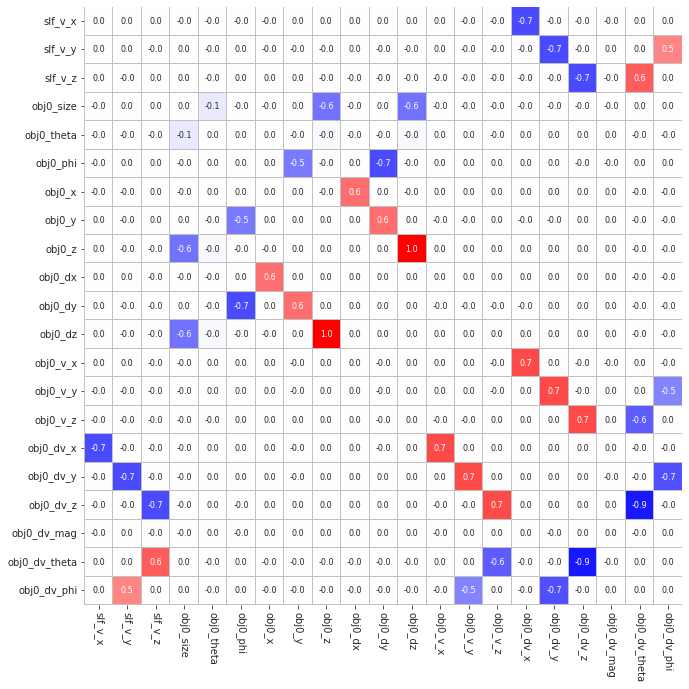

In [30]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_aux[:, accept], metric='correlation'))
np.fill_diagonal(rho, 0)

kws_hm = dict(
    xticklabels=f_aux,
    yticklabels=f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(13, 11),
    cbar=False,
)
show_heatmap(rho, **kws_hm);

In [31]:
g_full = np.concatenate([g, g_aux])
g_full.shape

(32, 1000000)

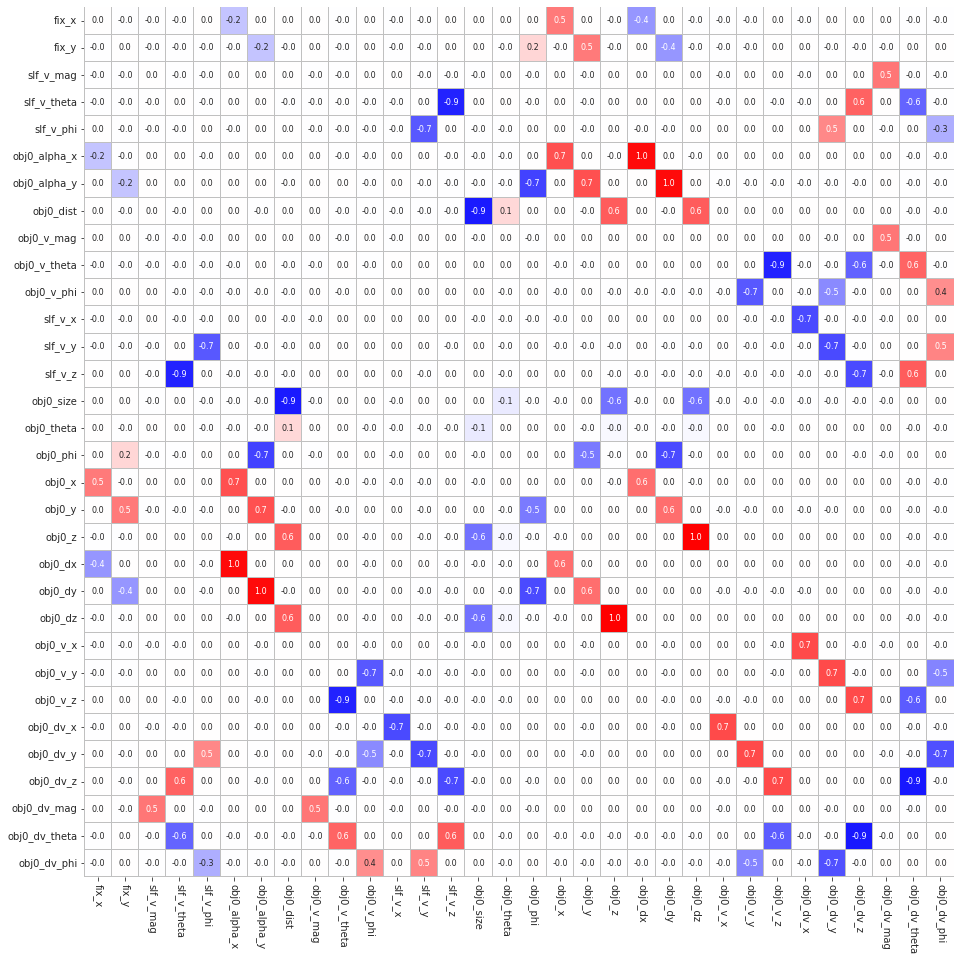

In [32]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_full[:, accept], metric='correlation'))
np.fill_diagonal(rho, 0)

kws_hm = dict(
    xticklabels=f + f_aux,
    yticklabels=f + f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(17, 16),
    cbar=False,
)
show_heatmap(rho, **kws_hm);

## kNN

In [33]:
%%time

knn = sk_neigh.NearestNeighbors(n_neighbors=3, metric='euclidean').fit(g.T)
neigh_dist, neigh_ind = knn.kneighbors(g.T)
neigh_dist.shape, neigh_ind.shape

CPU times: user 12min 24s, sys: 74.1 ms, total: 12min 24s
Wall time: 12min 24s


((1000000, 3), (1000000, 3))

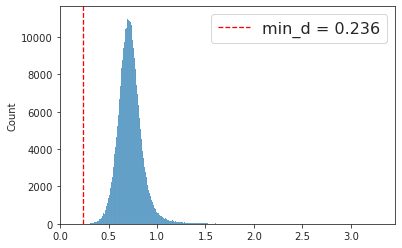

In [34]:
ax = sns.histplot(neigh_dist[:, 1])
min_d = min(neigh_dist[:, 1])
ax.axvline(min_d, color='r', ls='--', lw=1.3, label=f"min_d = {min_d:0.3f}")
ax.legend(fontsize=16)
ax.set_xlim(left=0);

In [35]:
closest_i = np.argmin(neigh_dist[:, 1])
closest_i

51624

In [36]:
neigh_dist[closest_i], neigh_ind[closest_i]

(array([0.        , 0.23635256, 0.61770737]), array([ 51624, 598339, 394694]))

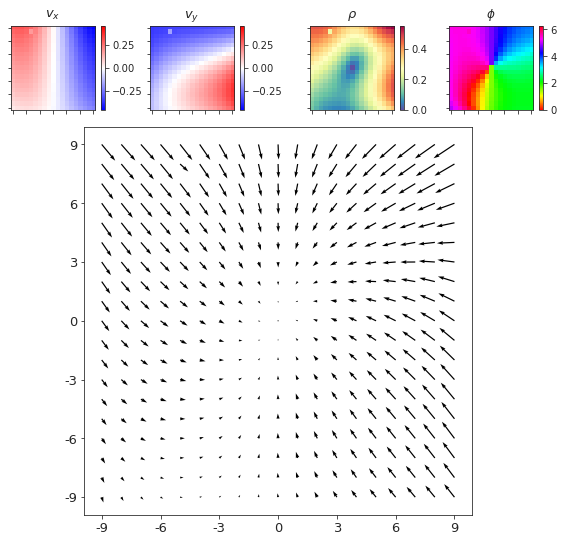

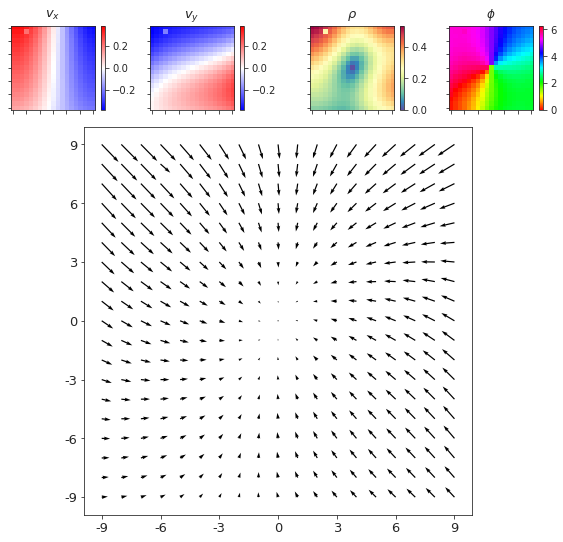

In [37]:
show_opticflow_full(of.alpha_dot[neigh_ind[closest_i, 0]])
show_opticflow_full(of.alpha_dot[neigh_ind[closest_i, 1]]);

### kNN across different seeds

In [38]:
kws = {
    'category': 'fixate',
    'n': int(1e4),
    'n_obj': 1,
    **kws,
}
print(kws)

{
    'category': 'fixate',
    'n': 10000,
    'n_obj': 1,
    'dim': 19,
    'fov': 45.0,
    'obj_r': 0.2,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 5.0),
    'vlim_slf': (0.01, 5.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

In [39]:
%%time

g_dict = {}
for seed in range(100):
    kws['seed'] = seed
    of = OpticFlow(**kws).compute_coords()
    _ = of.compute_flow()
    accept = of.filter(min_obj_size)
    _, g, *_ = of.groundtruth_factors()
    g_dict[seed] = g
    
g_all = np.concatenate(list(g_dict.values()), axis=-1)
g_all.shape

CPU times: user 15min 12s, sys: 35.9 s, total: 15min 48s
Wall time: 15min 48s


(11, 1000000)

In [40]:
%%time

knn = sk_neigh.NearestNeighbors(n_neighbors=3, metric='euclidean').fit(g_all.T)
neigh_dist, neigh_ind = knn.kneighbors(g_all.T)
neigh_dist.shape, neigh_ind.shape

CPU times: user 12min 30s, sys: 63.7 ms, total: 12min 30s
Wall time: 12min 30s


((1000000, 3), (1000000, 3))

#### mean and standard deviation of g

In [41]:
mu, sd = g_all.mean(1), g_all.std(1) 

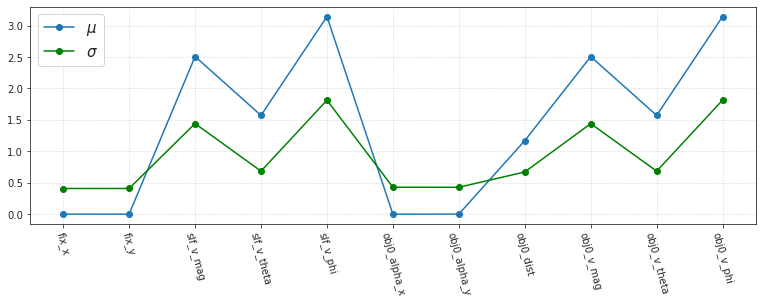

In [42]:
fig, ax = create_figure(1, 1, (13, 4))
ax.plot(mu, marker='o', label=r"$\mu$")
ax.plot(sd, marker='o', label=r"$\sigma$", color='g')
ax.set(xticks=range(len(f)), xticklabels=f)
ax.tick_params(axis='x', rotation=-75)
ax.legend(fontsize=15)
ax.grid()
plt.show()

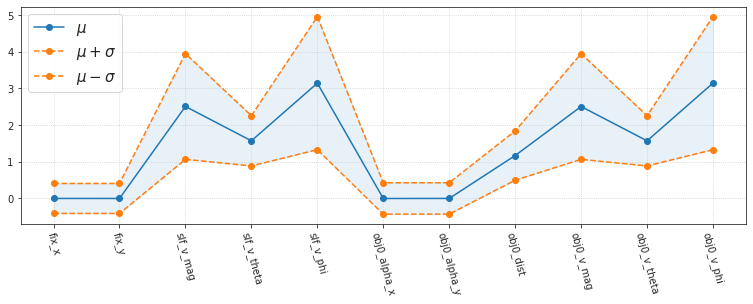

In [43]:
fig, ax = create_figure(1, 1, (13, 4))
ax.plot(mu, marker='o', label=r"$\mu$")
ax.fill_between(x=range(len(mu)), y1=mu - sd, y2=mu + sd, color='C0', alpha=0.1, zorder=0)
ax.plot(mu + sd, marker='o', color='C1', ls='--', label=r"$\mu + \sigma$")
ax.plot(mu - sd, marker='o', color='C1', ls='--', label=r"$\mu - \sigma$")

ax.set(xticks=range(len(f)), xticklabels=f)
ax.tick_params(axis='x', rotation=-75)
ax.legend(fontsize=15)
ax.grid()
plt.show()

#### Distribution of nearest neighbor distances

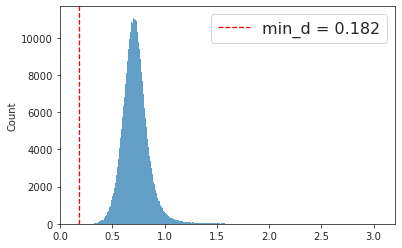

In [44]:
ax = sns.histplot(neigh_dist[:, 1])
min_d = min(neigh_dist[:, 1])
ax.axvline(min_d, color='r', ls='--', lw=1.3, label=f"min_d = {min_d:0.3f}")
ax.legend(fontsize=16)
ax.set_xlim(left=0);

In [45]:
closest_i = np.argmin(neigh_dist[:, 1])
closest_i

412376

In [46]:
neigh_dist[closest_i], neigh_ind[closest_i]

(array([0.        , 0.18188845, 0.56361845]), array([412376, 973958, 134331]))

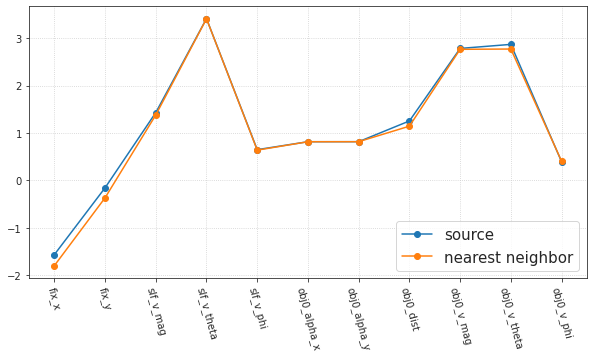

In [48]:
fig, ax = create_figure(1, 1, (10, 5))
ax.plot(g_all[:, neigh_ind[closest_i, 0]] / sd, marker='o', label='source')
ax.plot(g_all[:, neigh_ind[closest_i, 1]] / sd, marker='o', label='nearest neighbor')
ax.set(xticks=range(len(f)), xticklabels=f)
ax.tick_params(axis='x', rotation=-75)
ax.legend(fontsize=15)
ax.grid()
plt.show()

***Conclusion:*** It is possible to generate stimuli over many iterations using different seeds in each iteration and still get different results.